In [1]:
import numpy as np
from scipy.signal import hanning

def general_cosine(x, a):
    w = np.zeros_like(x)
    for k in range(len(a)):
        w += a[k] * np.cos(k * x)

    return w

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def radial_window_mask(window_size: tuple, theta_shift=0., r: float = np.pi, window_type: str = 'blackman'):
    if window_type.lower() == 'hanning':
        a = [0.5] * 2
    elif window_type.lower() == 'blackman':
        a = [0.42, 0.50, 0.08]
    m, n = window_size

    xx, yy = np.meshgrid(
        np.linspace(-r, r, n, dtype=np.float32),
        np.linspace(-r, r, m, dtype=np.float32),
        indexing='xy'
    )

    rho, phi = cart2pol(xx, yy)

    return general_cosine(rho + theta_shift, a)

def square_window_mask(window_size: tuple, theta_shift=0., r: float = np.pi, window_type: str = 'blackman'):
    if window_type.lower() == 'hanning':
        a = [0.5] * 2
    elif window_type.lower() == 'blackman':
        a = [0.42, 0.50, 0.08]
    m, n = window_size

    xx, yy = np.meshgrid(
        np.arange(n, dtype=np.float32),
        np.arange(m, dtype=np.float32),
        indexing='xy'
    )

    rho, phi = cart2pol(xx - n / 2, yy - m / 2)

    R = np.sqrt((m / 2) ** 2 + (n / 2) ** 2)

    bins = m * R / (np.abs(R * np.cos(phi) - R * np.sin(phi)) + \
        np.abs(R * np.cos(phi) + R * np.sin(phi)))

    start = -r
    stop = r

    delta = stop - start
    step = delta / bins

    return general_cosine(rho * step + theta_shift, a)

    



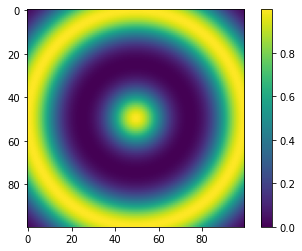

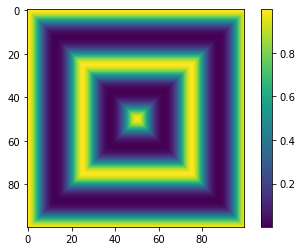

In [2]:
import matplotlib.pyplot as plt

window = radial_window_mask((100, 100), theta_shift=0, r=2*np.pi)

plt.figure()
plt.imshow(window)
plt.colorbar()

window_ = square_window_mask((100, 100), r=2*np.pi, theta_shift=0)

plt.figure()
plt.imshow(window_)
plt.colorbar()



/home/mattsmith/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mattsmith/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352465323/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


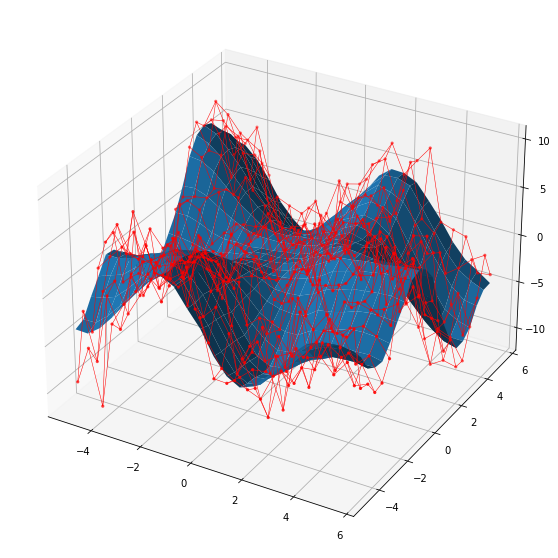

In [3]:
from sgolay2 import SGolay2d
from mpl_toolkits.mplot3d import Axes3D
import torch

torch.random.manual_seed(12345)

xx, yy = torch.meshgrid(
    torch.arange(-5, 6, 0.5, dtype=torch.float32),
    torch.arange(-5, 6, 0.5, dtype=torch.float32),
    indexing='xy'
)

zz = yy * torch.sin(xx) + xx * np.cos(yy)
noise = torch.randn(*xx.shape) * 2.
zn = zz + noise

sg = SGolay2d(window_size=9, order=3)
zs = sg(zn.view(1, 1, *zn.shape))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zn, linewidths=0.5, color='r')
ax.scatter(xx, yy, zn, s=5, c='r')
ax.plot_surface(xx, yy, zs.squeeze(), linewidth=0)

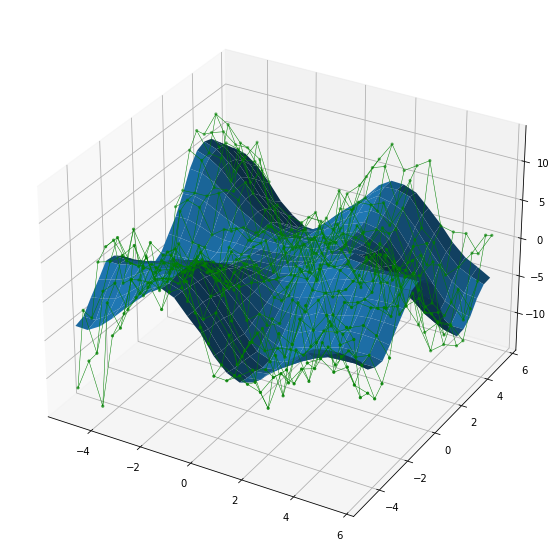

In [4]:
noise_approx = zn - zs.squeeze()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# ax.plot_wireframe(xx, yy, noise, linewidths=0.5, color='r')
# ax.scatter(xx, yy, noise, s=5, c='r')
ax.plot_wireframe(xx, yy, zz + noise_approx, linewidths=0.5, color='g')
ax.scatter(xx, yy, zz + noise_approx, s=5, c='g')
ax.plot_surface(xx, yy, zs.squeeze(), linewidth=0)

In [27]:
from argrelextrema import relextrema2d

mask = relextrema2d(zn, torch.greater, order=5)

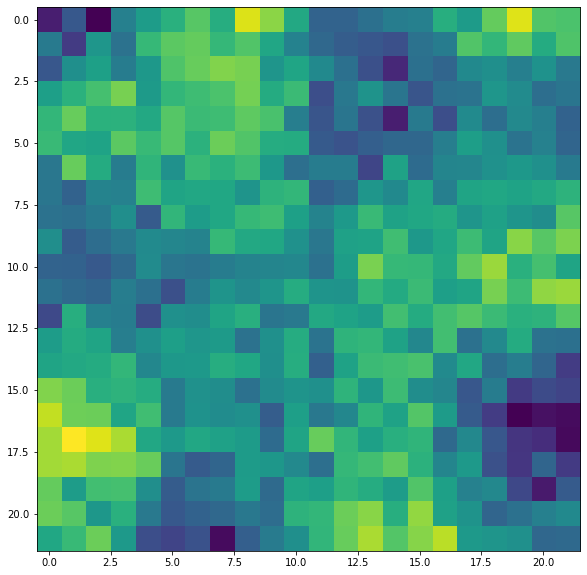

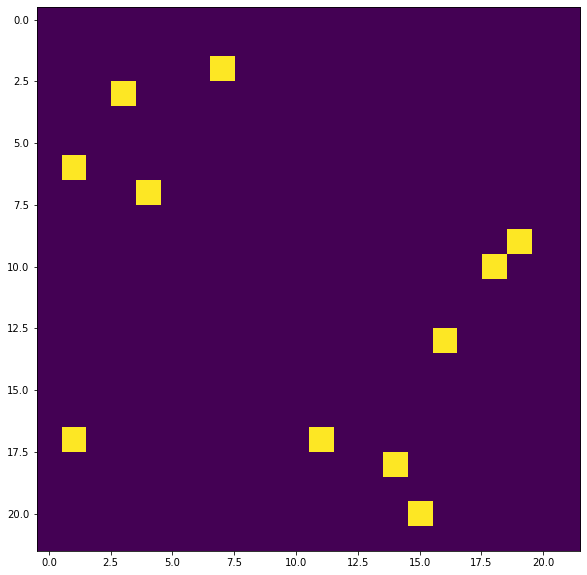

In [28]:
indices = torch.nonzero(mask)

plt.figure(figsize=(10, 10))
plt.imshow(zn)

plt.figure(figsize=(10, 10))
plt.imshow(mask)


